This notebook demonstrates the use of `scikit-learn` for a simple binary classification task. In particular, it shows how to split a labeled dataset into training and testing splits, fit several classifiers, and use the `GridSearchCV` estimator to conduct a hyperparameter search for a given classifier.

The following code block imports libraries we will use.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from tqdm.auto import tqdm

The following code block reads the dataset we will use into a `polars` `DataFrame` and use the `.head()` method to print the first five rows. The dataset was downloaded from https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data (last accessed 7/14/2024).

In [2]:
data = pl.read_csv(
    'diabetes_prediction_dataset.csv'
)

data.head()

gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
str,f64,i64,i64,str,f64,f64,i64,i64
"""Female""",80.0,0,1,"""never""",25.19,6.6,140,0
"""Female""",54.0,0,0,"""No Info""",27.32,6.6,80,0
"""Male""",28.0,0,0,"""never""",27.32,5.7,158,0
"""Female""",36.0,0,0,"""current""",23.45,5.0,155,0
"""Male""",76.0,1,1,"""current""",20.14,4.8,155,0


The following code block uses the `shape` attribute to show the number of rows and columns.

In [3]:
data.shape

(100000, 9)

Setting `generate_plot=True` in the following code block will generate a plot showing how the values in the `diabetes` column vary as the values in other columns change.

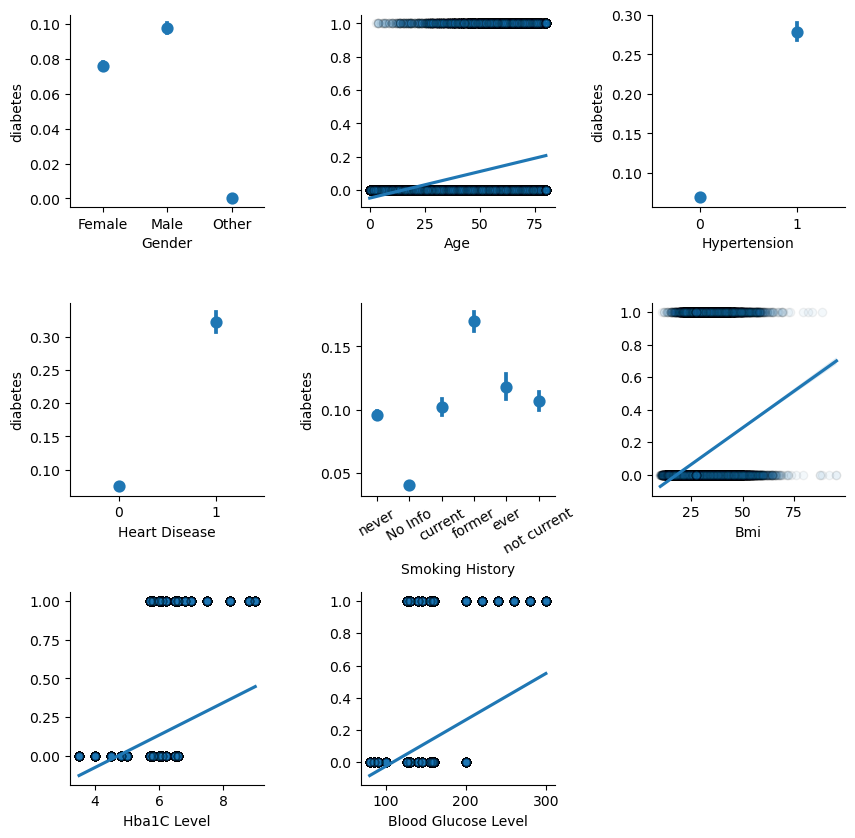

In [4]:
generate_plot = True

if generate_plot:

    plot_mapper = {
        'gender': 'pointplot',
        'age': 'regplot',
        'hypertension': 'pointplot',
        'heart_disease': 'pointplot',
        'smoking_history': 'pointplot',
        'bmi': 'regplot',
        'HbA1c_level': 'regplot',
        'blood_glucose_level': 'regplot',
    }
    
    mosaic = [
        ['gender', 'age', 'hypertension'],
        ['heart_disease', 'smoking_history', 'bmi'],
        ['HbA1c_level', 'blood_glucose_level', '.'],
    ]
    
    fig, ax = plt.subplot_mosaic(mosaic, figsize=(10, 10))
    
    for column_label, plot_type in plot_mapper.items():
        if plot_type =='regplot':
            sns.regplot(
                data=data,
                x=column_label,
                y='diabetes',
                scatter_kws={'alpha': 0.05, 'edgecolor': 'k'},
                ax=ax[column_label],
            )
        elif plot_type =='pointplot':
            sns.pointplot(
                data=data,
                x=column_label,
                y='diabetes',
                linestyle='none',
                ax=ax[column_label],
            )
    
        ax[column_label].spines[['right', 'top']].set_visible(False)
        ax[column_label].set_xlabel(column_label.replace('_', ' ').title())
        if column_label == 'smoking_history':
            ax[column_label].tick_params(
                axis='x',
                labelrotation=30,
            )
    
    plt.subplots_adjust(
        hspace=0.5,
        wspace=0.5,
    )

    plt.savefig(
        'diabetes_impacts.pdf', 
        bbox_inches='tight',
    )
    plt.show()

Before starting to train a binary classifier, we need to use "one-hot encoding" to convert the columns containing categorical values into numeric representations.

In [5]:
data = pl.read_csv(
    'diabetes_prediction_dataset.csv'
).to_dummies(
    ['gender', 'smoking_history'],
    drop_first=True,
)

The following code block species the target, i.e., the variable we want to learn to predict, and the features, i.e., the variables we suspect may be predictive.

In [6]:
target = 'diabetes'
features = [col for col in data.columns if col != target]

The following code block uses `seaborn` to generate a heatmap showing the correlation between features.

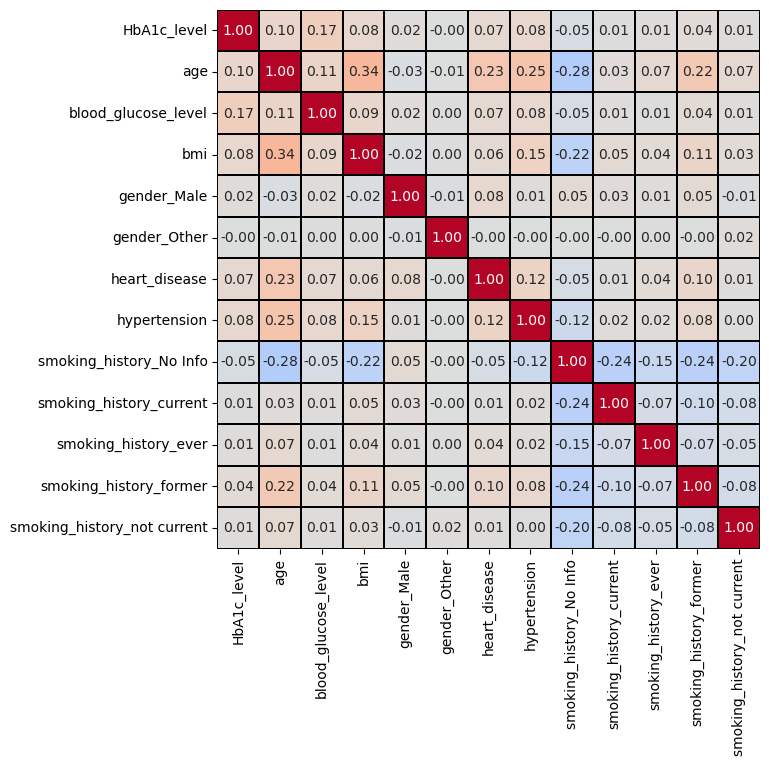

In [7]:
correlation_df = data[features].to_pandas().corr().sort_index(
    axis='index'
).sort_index(
    axis='columns'
)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.heatmap(
    correlation_df,
    cmap='coolwarm',
    vmin=-1.0,
    vmax=1.0,
    cbar=False,
    annot=True,
    fmt='.2f',
    linewidths=0.1,
    linecolor='k',
)

plt.show()

The following code block computes the mean of the target variable column. As it shows, approximately 8.5% of the values are positive.

In [8]:
data[target].mean()

0.085

We will now split the dataset into two sets: 1) a training set and 2) a testing set. The following code block imports a function from `scikit-learn` that simplifies this process.

In [9]:
from sklearn.model_selection import train_test_split

The following code block performs the dataset splitting.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    data[features], 
    data[target],
    test_size=0.20,
    stratify=data[target],
    random_state=12,
)

print(f' - {y_train.mean() = }')
print(f' - {y_test.mean() = }')

 - y_train.mean() = 0.085
 - y_test.mean() = 0.085


The first classifier we will fit is a simple decision tree. The following code block imports the classifier object and a function that allows us to visualize the classifier's decision logic.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

The following code block fits the classifier and prints its performance (i.e., accuracy) on the training and testing sets.

In [12]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

print(f' - {clf.score(X_train, y_train) = }')
print(f' - {clf.score(X_test, y_test) = }')

 - clf.score(X_train, y_train) = 0.9992125
 - clf.score(X_test, y_test) = 0.9519


The following code block uses a `scikit-learn` function to generate a confusion matrix for the classifier's performance on the testing dataset.

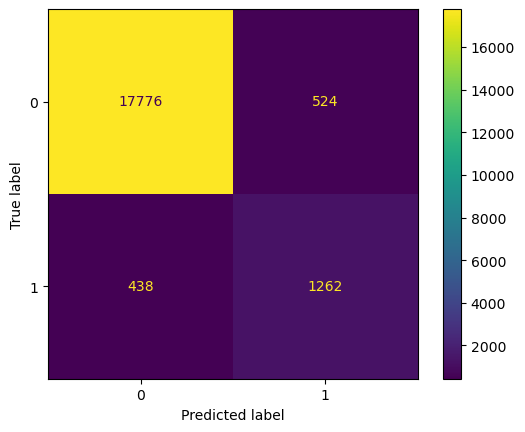

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    estimator=clf,
    X=X_test,
    y=y_test,
);

Setting `show_tree=True` in the following cell will print a text depiction of the decision tree's decision logic.

In [14]:
show_tree = True

if show_tree:
    dt_string = export_text(
        decision_tree=clf,
        feature_names=features,
    )
    
    print(dt_string)

|--- HbA1c_level <= 6.70
|   |--- blood_glucose_level <= 210.00
|   |   |--- age <= 54.50
|   |   |   |--- hypertension <= 0.50
|   |   |   |   |--- bmi <= 39.84
|   |   |   |   |   |--- age <= 42.50
|   |   |   |   |   |   |--- HbA1c_level <= 5.35
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- HbA1c_level >  5.35
|   |   |   |   |   |   |   |--- age <= 27.50
|   |   |   |   |   |   |   |   |--- blood_glucose_level <= 113.00
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- blood_glucose_level >  113.00
|   |   |   |   |   |   |   |   |   |--- bmi <= 19.88
|   |   |   |   |   |   |   |   |   |   |--- blood_glucose_level <= 180.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |   |--- blood_glucose_level >  180.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |--- bmi >  19.88
|   |   |   |   | 

The following code block refits the decision tree with the `max_depth` hyperparameter set to `3`.

In [15]:
clf = DecisionTreeClassifier(
    max_depth=3,
    random_state=42,
)
clf.fit(X_train, y_train)

print(f' - {clf.score(X_train, y_train) = }')
print(f' - {clf.score(X_test, y_test) = }')

 - clf.score(X_train, y_train) = 0.97185
 - clf.score(X_test, y_test) = 0.97195


The confusion matrix for the revised classifier is plotted by the following code block.

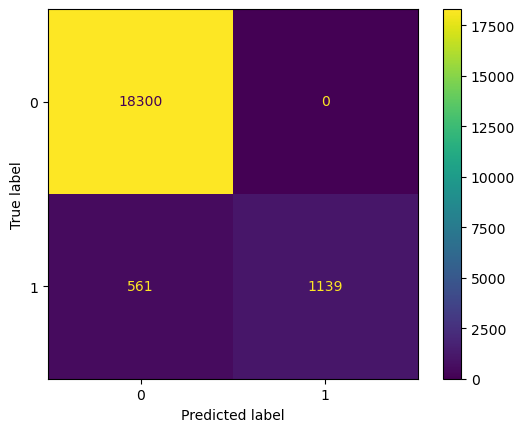

In [16]:
ConfusionMatrixDisplay.from_estimator(
    estimator=clf,
    X=X_test,
    y=y_test,
);

Setting `show_tree=True` in the following cell will print a text depiction of the decision tree's decision logic.

In [17]:
show_tree = True

if show_tree:
    dt_string = export_text(
        decision_tree=clf,
        feature_names=features,
    )
    
    print(dt_string)

|--- HbA1c_level <= 6.70
|   |--- blood_glucose_level <= 210.00
|   |   |--- age <= 54.50
|   |   |   |--- class: 0
|   |   |--- age >  54.50
|   |   |   |--- class: 0
|   |--- blood_glucose_level >  210.00
|   |   |--- class: 1
|--- HbA1c_level >  6.70
|   |--- class: 1



To conduct a more extensive search of the hyperparameters, we will use the `GridSearchCV` estimator from `scikit-learn`. The following code block imports the estimator.

In [18]:
from sklearn.model_selection import GridSearchCV

The following code block uses the `GridSearchCV` estimator to determine the *best* hyperparameter settings out of the combinations considered.

 - best_clf.score(X_train, y_train) = 0.97185
 - best_clf.score(X_test, y_test) = 0.97195


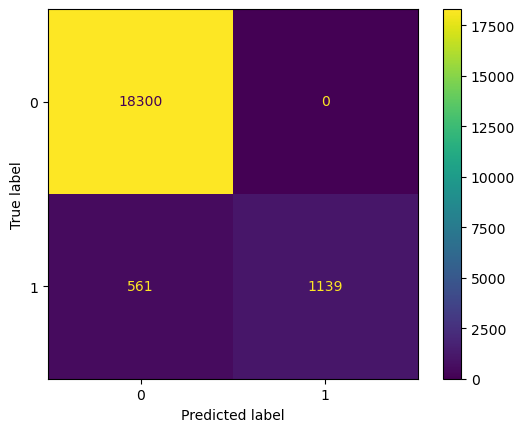

In [19]:
base_clf = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [2, 3, 4, 5],
    'criterion': ['gini', 'entropy'],
}

grid = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid,
    scoring='recall',
    n_jobs=-1,
)
grid.fit(X_train, y_train)

best_clf = grid.best_estimator_

print(f' - {best_clf.score(X_train, y_train) = }')
print(f' - {best_clf.score(X_test, y_test) = }')

ConfusionMatrixDisplay.from_estimator(
    estimator=best_clf,
    X=X_test,
    y=y_test,
);

Setting `show_tree=True` in the following cell will print a text depiction of the decision tree's decision logic.

In [20]:
show_tree = True

if show_tree:
    dt_string = export_text(
        decision_tree=best_clf,
        feature_names=features,
    )
    
    print(dt_string)

|--- HbA1c_level <= 6.70
|   |--- blood_glucose_level <= 210.00
|   |   |--- class: 0
|   |--- blood_glucose_level >  210.00
|   |   |--- class: 1
|--- HbA1c_level >  6.70
|   |--- class: 1



The following code block fits a `RandomForestClassifier`.

 - best_clf.score(X_train, y_train) = 0.97185
 - best_clf.score(X_test, y_test) = 0.97195


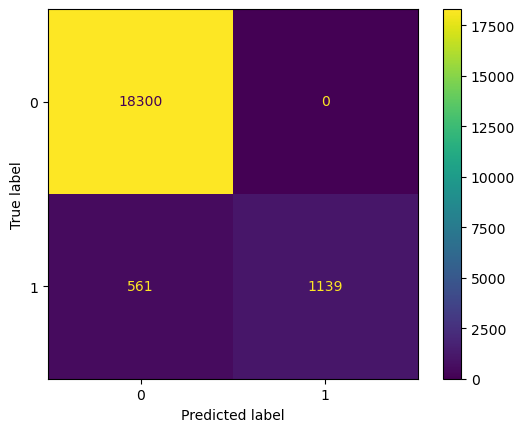

In [21]:
from sklearn.ensemble import RandomForestClassifier

base_clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 4, 5],
    'criterion': ['gini', 'entropy'],
}

grid = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid,
    scoring='recall',
    n_jobs=-1,
)
grid.fit(X_train, y_train)

best_clf = grid.best_estimator_

print(f' - {best_clf.score(X_train, y_train) = }')
print(f' - {best_clf.score(X_test, y_test) = }')

ConfusionMatrixDisplay.from_estimator(
    estimator=best_clf,
    X=X_test,
    y=y_test,
);

The following code block fits a `HistGradientBoostingClassifier`.

 - best_clf.score(X_train, y_train) = 0.9727625
 - best_clf.score(X_test, y_test) = 0.9719


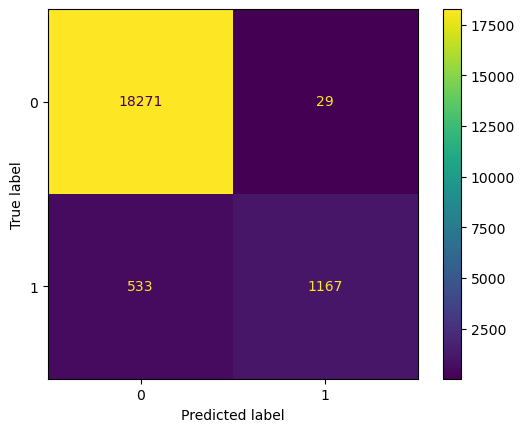

In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier

base_clf = HistGradientBoostingClassifier(random_state=42)

param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5],
}

grid = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid,
    scoring='recall',
    n_jobs=-1,
)
grid.fit(X_train, y_train)

best_clf = grid.best_estimator_

print(f' - {best_clf.score(X_train, y_train) = }')
print(f' - {best_clf.score(X_test, y_test) = }')

ConfusionMatrixDisplay.from_estimator(
    estimator=best_clf,
    X=X_test,
    y=y_test,
);

Instead of returning predicted class labels, the following code block shows how we can retrieve the probability that each instance belongs to the positive class.

In [23]:
positive_probabilities = best_clf.predict_proba(X_test)[:, 1]

The following code block demonstrates that `scikit-learn` is using a positive probability threshold of 0.50 by default.

In [24]:
from sklearn.metrics import confusion_matrix

threshold = 0.5

predictions = (positive_probabilities >= threshold)

tn, fp, fn, tp = confusion_matrix(y_test, predictions).flatten()

print(f' - {fp = :,}')
print(f' - {fn = :,}')

 - fp = 29
 - fn = 533


The following code block runs a simple experiment to observe how the number of false positive and false negatives vary as we change the positive probability threshold.

  0%|          | 0/99 [00:00<?, ?it/s]

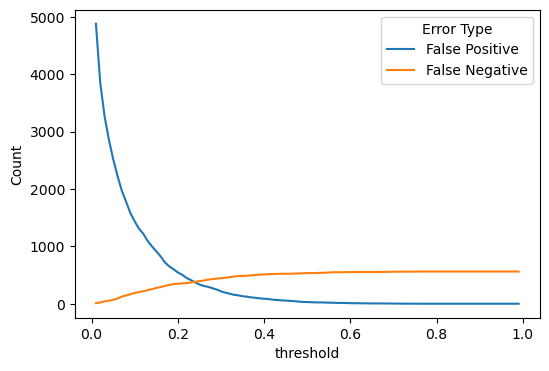

In [25]:
thresholds = np.arange(0.01, 1.00, 0.01)

experiment_data = []
for threshold in tqdm(thresholds):
    predictions = (positive_probabilities >= threshold)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).flatten()
    
    experiment_data.append({
        'threshold': threshold.round(2),
        'Error Type': 'False Positive',
        'Count': fp,
    })
    experiment_data.append({
        'threshold': threshold.round(2),
        'Error Type': 'False Negative',
        'Count': fn,
    })

experiment_data = pl.DataFrame(
    experiment_data
)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(
    data=experiment_data,
    x='threshold',
    y='Count',
    hue='Error Type',
)

plt.show()